<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Document Modeling with Gensim</center></font></h1>
<h1><center>Twitter Airline Sentiment Analysis</center></h1>
<h3><center>Charlcye Mitchell, April 2024</center></h3>

# **LVC 3: Deep Learning Primer - The World of Neural Networks**

# **Twitter Airline Sentiment Analysis**

## **Problem Statement**

Similar to earlier such problem statements, the aim of this notebook is to demonstrate a Sentiment Classifier - however, this time we will build and train and LSTM Neural Network to do this. This classifier will categorize the sentiment of tweets as positive, negative or neutral.

## **Data Dictionary**

* tweet_id - A unique identifier for each tweet                                                          
* airline_sentiment - The sentiment label of the tweet, such as positive, negative, or neutral                                               
* airline_sentiment_confidence - The confidence level associated with the sentiment label                               
* negativereason - A category indicating the reason for negative sentiment                                                   
* negativereason_confidence - The confidence level associated with the negative reason                                    
*airline - The airline associated with the tweet                                                                   
* airline_sentiment_gold - Gold standard sentiment label                                               
* name - The username of the tweet author    
* retweet_count - The number of times the tweet has been retweeted
* text - The actual text content of the tweet.
* tweet_coord - Coordinates of the tweet
* tweet_created - The timestamp when the tweet was created
* tweet_location - The location mentioned in the tweet
* user_timezone - The timezone of the tweet author

## **Importing the necessary libraries**

In [ ]:
# install and import necessary libraries.

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data = pd.read_csv("Tweets.csv")

In [ ]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# print shape of data
data.shape

(14640, 15)

In [ ]:
# Check for NULL values
data.isnull().sum(axis=0)

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

We would primarily using the 'text' and 'airline_sentiment' columns for our analysis and modeling, hence we would not treat the columns with missing values for this specific task

## **Exploratory Data Analysis**

In [ ]:

 # function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<ipython-input-6-3c7d73d3231a>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


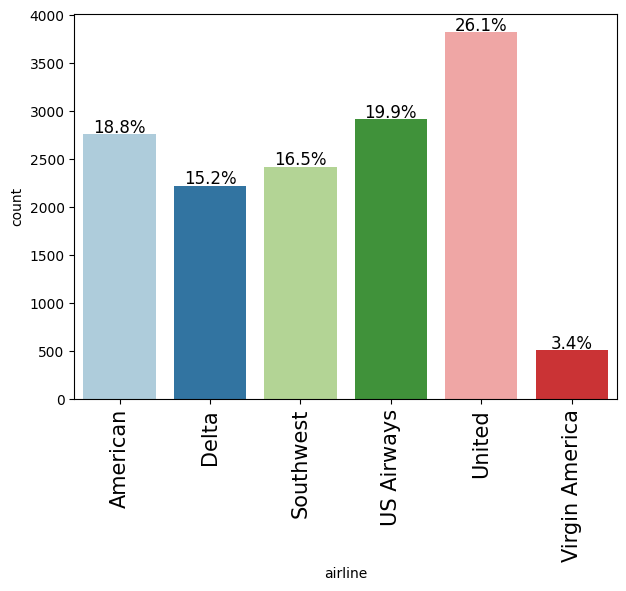

In [ ]:
labeled_barplot(data, "airline", perc=True)

 - **We can see the percentage of tweets for United Airline has the highest number of tweets i.e. 26%, followed by US Airways (20%)**.

<ipython-input-6-3c7d73d3231a>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


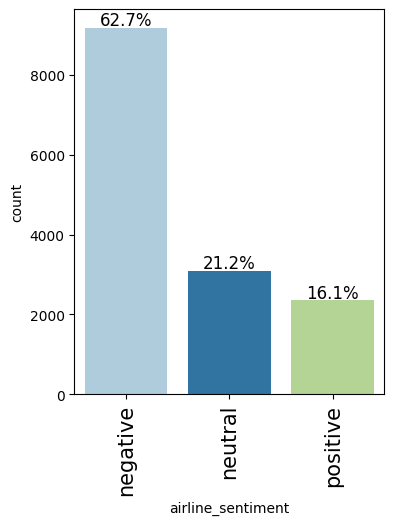

In [ ]:
labeled_barplot(data, "airline_sentiment", perc=True)

- **Majority of the tweets are negative (63%), followed by neutral tweets (21%), and then the positive tweets (16%).**

<Axes: xlabel='airline'>

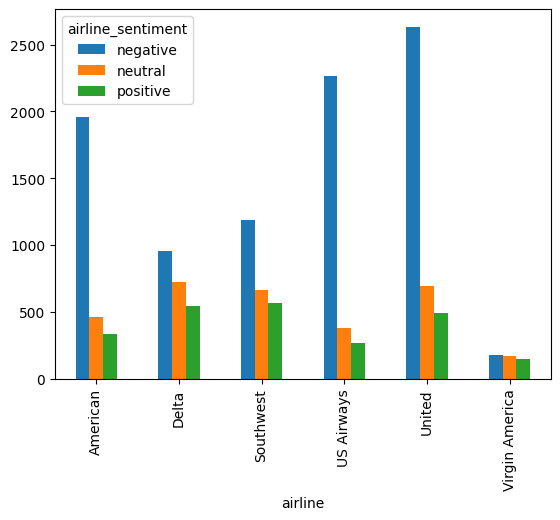

In [ ]:
airline_sentiment =  data.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

- **It is evident from the output that for almost all the airlines, the majority of the tweets are negative, followed by neutral and positive tweets. Virgin America is probably the only airline where the ratio of the three sentiments is somewhat similar.**

In [ ]:
airline_tweets=data[data['airline_sentiment']=='negative']
words = ' '.join(data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

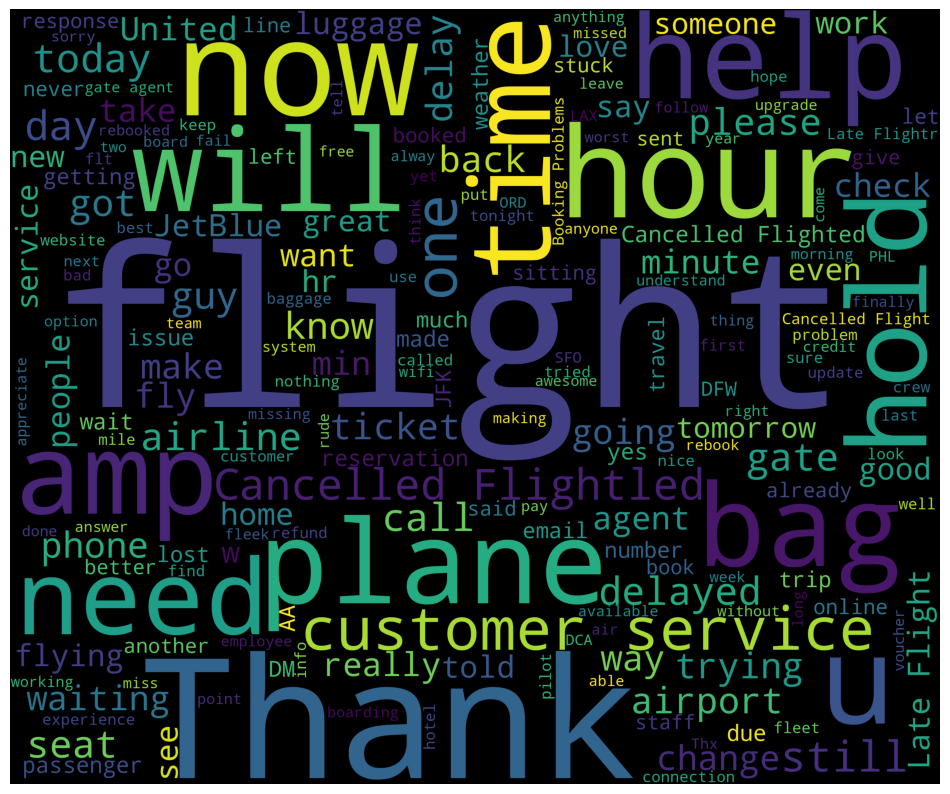

In [ ]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
airline_tweets=data[data['airline_sentiment']=='positive']
words = ' '.join(data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

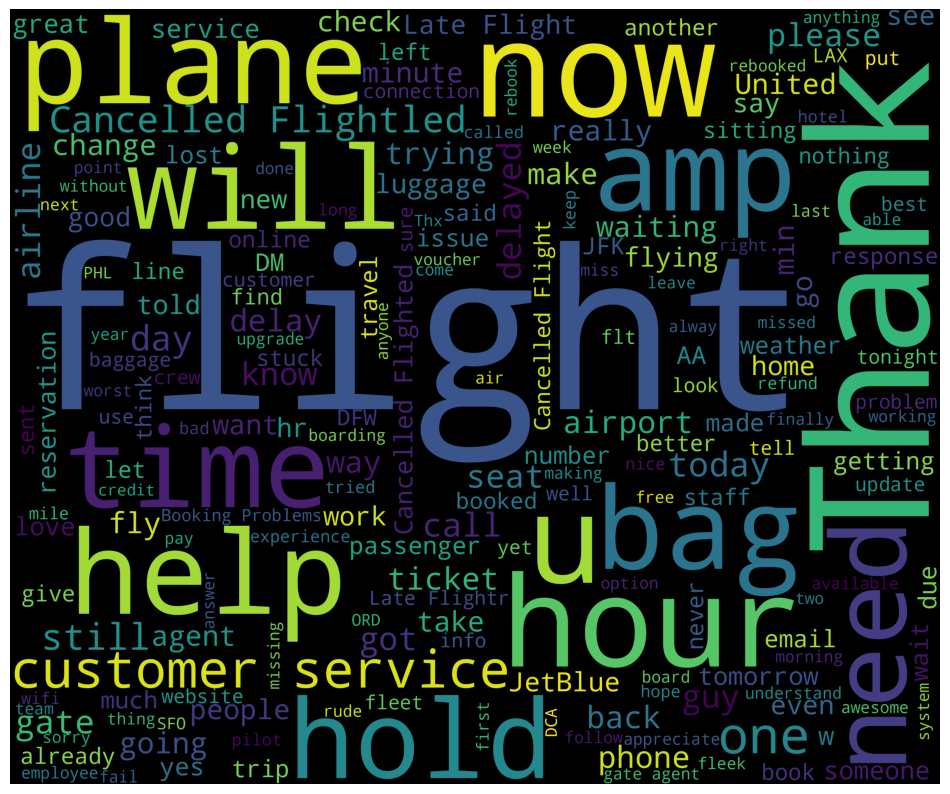

In [ ]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## **Data Preprocessing**

In [ ]:
df = data[['airline_sentiment', 'text']]


In [ ]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
df['text'][2]

"@VirginAmerica I didn't today... Must mean I need to take another trip!"

In [ ]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters, URLs, and user mentions
    text = re.sub(r"http\S+|www\S+|@[^\s]+", '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Join the cleaned words back into a string
    cleaned_text = ' '.join(words)

    return cleaned_text

# Assuming you have a DataFrame df with a 'text' column
df['text'] = df['text'].apply(preprocess_text)

<ipython-input-19-537ec6834354>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(preprocess_text)


In [ ]:
df['text'][2]

'didnt today must mean need take another trip'

##**Gensim**

**Gensim** is an open-source Python library designed for natural language processing (NLP) and machine learning tasks, with a particular focus on topic modeling and document similarity analysis. It is widely used for working with text data and building Word Embeddings like Word2Vec. Here are some key aspects of the Gensim library:

1) **Word Embeddings (Word2Vec)**: Gensim is known for its implementation of Word2Vec, a popular word embedding technique that converts words into dense vectors. These vectors capture semantic relationships between words, making them useful for various NLP tasks like text classification, sentiment analysis, and information retrieval.

2) **Topic Modeling**: Gensim provides efficient implementations of topic modeling algorithms, such as Latent Dirichlet Allocation (LDA) and Latent Semantic Analysis (LSA). These algorithms help extract topics from a collection of documents and discover latent semantic structures within text data.

3) **Document Similarity**: Gensim offers tools for measuring document similarity using techniques like cosine similarity. This is valuable for tasks such as finding similar documents or identifying related content.

4) **Text Preprocessing**: Gensim includes utilities for text preprocessing, such as tokenization, stop-word removal, and stemming or lemmatization. These preprocessing steps are crucial for preparing text data for modeling.

5) **Easy-to-Use API**: Gensim provides a straightforward API that allows users to train Word2Vec models, perform topic modeling, and calculate document similarity with ease.

In [ ]:
## pip install gensim

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize the text (assuming you haven't done it already)
df['tokenized_text'] = df['text'].apply(word_tokenize)

# Train a Word2Vec model
model = Word2Vec(df['tokenized_text'], vector_size=100, window=5, min_count=1, sg=0)

# Save the model if needed
model.save("word2vec_model")


<ipython-input-22-6e093b021344>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df['text'].apply(word_tokenize)


In [ ]:
df.head()

,airline_sentiment,text,tokenized_text
0,neutral,said,[said]
1,positive,plus youve added commercials experience tacky,"[plus, youve, added, commercials, experience, ..."
2,neutral,didnt today must mean need take another trip,"[didnt, today, must, mean, need, take, another..."
3,negative,really aggressive blast obnoxious entertainmen...,"[really, aggressive, blast, obnoxious, enterta..."
4,negative,really big bad thing,"[really, big, bad, thing]"


## **Model Building using an LSTM**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



In [ ]:
# Load the Word2Vec model
word2vec_model = Word2Vec.load("word2vec_model")

In [ ]:
# Use the 'tokenized_text' column for X
X_text_tokens = df['text'].to_list()

In [ ]:
# Convert text tokens to numerical sequences using the tokenizer
tokenizer = Tokenizer()

X = tokenizer.texts_to_sequences(X_text_tokens)

celebrate:


[456,3456,43676,34677,344354,356,3454]

[456,3456,43676,34677,344354,356,3454,0,0,0]


In [ ]:
# Pad sequences to a fixed length
max_sequence_length = 100  # You can adjust this based on your data
X = pad_sequences(X, maxlen=max_sequence_length, padding='post', truncating='post', dtype='float32')


In [ ]:
# Prepare Target Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['airline_sentiment'])
y_one_hot = to_categorical(y_encoded)

In [ ]:
df['airline_sentiment'][:5]

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

In [ ]:
y_encoded[:5]

array([1, 2, 1, 0, 0])

In [ ]:
y_one_hot[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
# Create an embedding matrix that matches the Word2Vec model's vectors
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [ ]:
embedding_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [ ]:
# Define the LSTM model
embedding_dim = word2vec_model.vector_size  # Size of the Word2Vec vectors
num_classes = 3  # Number of sentiment classes (e.g., positive, neutral, negative)

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_dim,
                    input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split =0.1)

Epoch 1/5
165/165 [==============================] - 142s 789ms/step - loss: 0.9404 - accuracy: 0.6231 - val_loss: 0.9303 - val_accuracy: 0.6152
Epoch 2/5
165/165 [==============================] - 129s 780ms/step - loss: 0.9227 - accuracy: 0.6231 - val_loss: 0.9299 - val_accuracy: 0.6152
Epoch 3/5
165/165 [==============================] - 120s 726ms/step - loss: 0.9213 - accuracy: 0.6231 - val_loss: 0.9305 - val_accuracy: 0.6152
Epoch 4/5
165/165 [==============================] - 114s 694ms/step - loss: 0.9216 - accuracy: 0.6231 - val_loss: 0.9300 - val_accuracy: 0.6152
Epoch 5/5
165/165 [==============================] - 116s 705ms/step - loss: 0.9211 - accuracy: 0.6231 - val_loss: 0.9299 - val_accuracy: 0.6152


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

92/92 [==============================] - 8s 86ms/step - loss: 0.8960 - accuracy: 0.6452
Test Loss: 0.8960, Test Accuracy: 0.6452


In [ ]:
y_pred = model.predict(X_test)

92/92 [==============================] - 12s 130ms/step


In [ ]:
y_pred = (y_pred > 0.5).astype(int)

In [ ]:
from sklearn.metrics import f1_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
f1 = f1_score(y_test, y_pred, average='weighted')  # You can use 'micro', 'macro', 'weighted', or 'samples' for the 'average' parameter

print(f"F1-Score: {f1:.4f}")

F1-Score: 0.5060


**Test Loss (0.9020)**: The test loss value of 0.9020 indicates the average discrepancy between the model's predicted probabilities and the actual target values in the test dataset. A lower test loss suggests that the model's predictions are closer to the true values.

**Test Accuracy (0.6452)**: The test accuracy value of 0.6452 means that the model correctly classified approximately 64.52% of the data points in the test dataset. While this accuracy is moderate, it provides a general measure of the model's classification performance.

**F1-Score (0.6495)**: The F1-score of 0.6495 provides a more comprehensive assessment of the model's performance, taking into account both precision and recall. It indicates how well the model balances precision and recall, particularly relevant in cases with imbalanced class distributions.

## **Key Takeaways**

- While this notebook is meant to serve as a demonstration for how to build an LSTM for a typical Sentiment Analysis task, we can see that the performance of this LSTM on the task is somewhat below par (F1 Score of only around 65%), despite accounting for the fact that Multi-class Classification is a harder task than Binary Classification.

- A range of methods could be used to try and improve this LSTM's performance, such as tweaking the depth, structure and hyperparameters of the model architecture, or training for a higher number of epochs.